In [2]:
# Packages importieren
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, precision_recall_curve, roc_curve, auc

In [3]:
# Daten importieren
X = pd.read_csv("../EDA/features.csv")
y = pd.read_csv("../EDA/targets.csv")

In [4]:
# Datenaufteilung nach Verhältnis 7:2:1
# Originäre Datensatz --> 1.Split:  _temp 80% & _test 20%; 2.Split: _temp --> _train 70% & _val 10% (80*0.125)
# stratify --> Klassenverhältnis 1:9 zu behalten

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

print("Der Datensatz wurde aufgeteilt!")

Der Datensatz wurde aufgeteilt!


In [5]:
df = pd.concat([X_train, y_train], axis=1)
duplicates = df[df.duplicated(keep=False)]
print(f"Anzahl Duplikate: {len(duplicates)}")

df_clean = df.drop_duplicates()
print("Duplikate wurde entfernt!")

Anzahl Duplikate: 21438
Duplikate wurde entfernt!


In [6]:
y_train = df_clean[['Diabetes_binary']]
X_train = df_clean.drop(columns=['Diabetes_binary']).copy()

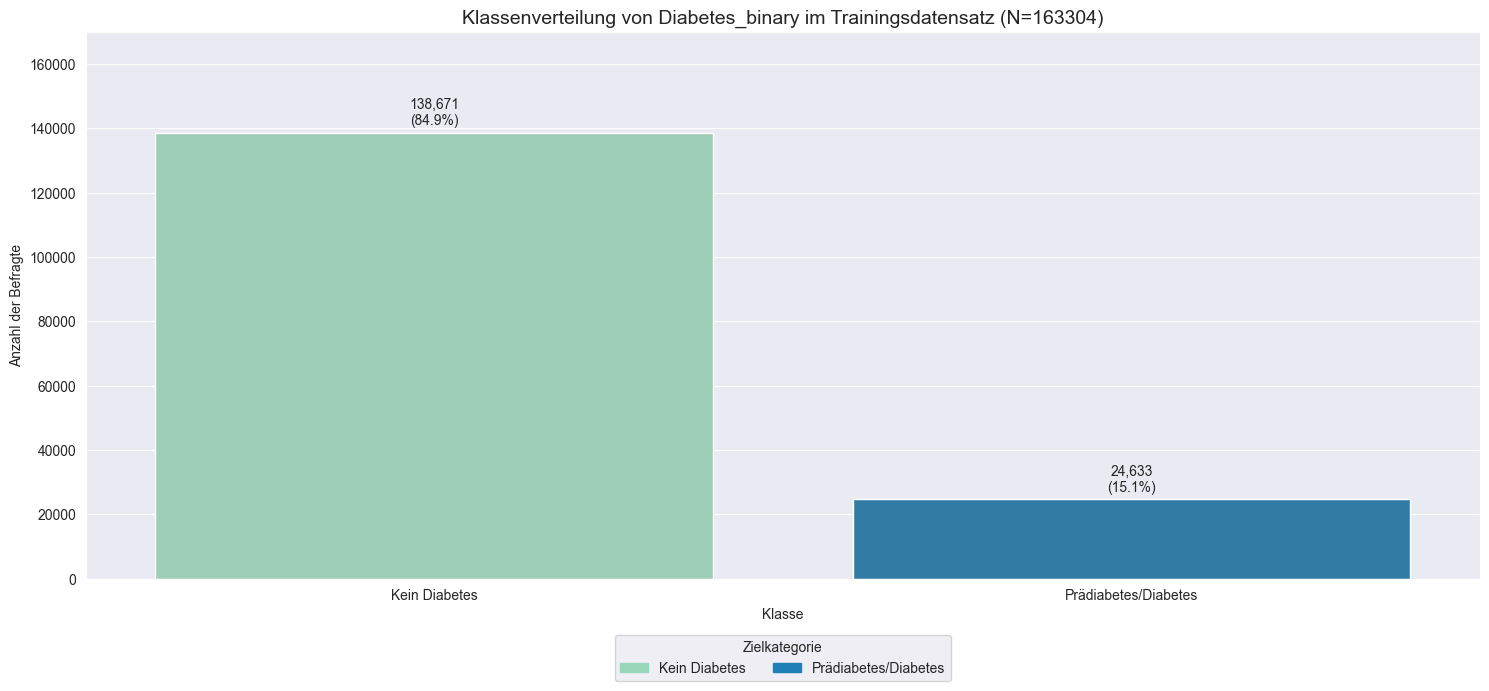

In [7]:
# Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_train, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary im Trainingsdatensatz (N=163304)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_train) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_train)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [250]:
# E_R_0: Performancebewertung
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, np.ravel(y_train))

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(np.ravel(y_test), y_proba)

print("E_R_0")
print(f"ROC AUC:   {roc_auc:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred))
print(confusion_matrix(np.ravel(y_test), y_pred))

E_R_0
ROC AUC:   0.819

              precision    recall  f1-score   support

           0       0.88      0.98      0.92     43667
           1       0.52      0.15      0.24      7069

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736

[[42663  1004]
 [ 5979  1090]]


In [251]:
# E_R_1: Oversampling mit RandomOverSampler auf Minderheitklasse
ros = RandomOverSampler(random_state=42)

X_ros, y_ros = ros.fit_resample(X_train, y_train)

X_ros = pd.DataFrame(X_ros, columns=X_train.columns, index=X_train.index)
y_ros = pd.DataFrame(y_ros, columns=y_train.columns, index=y_train.index)

print("Nach Random Over Sampling: ", y_ros.value_counts())

Nach Random Over Sampling:  Diabetes_binary
0                  88977
1                  74327
Name: count, dtype: int64


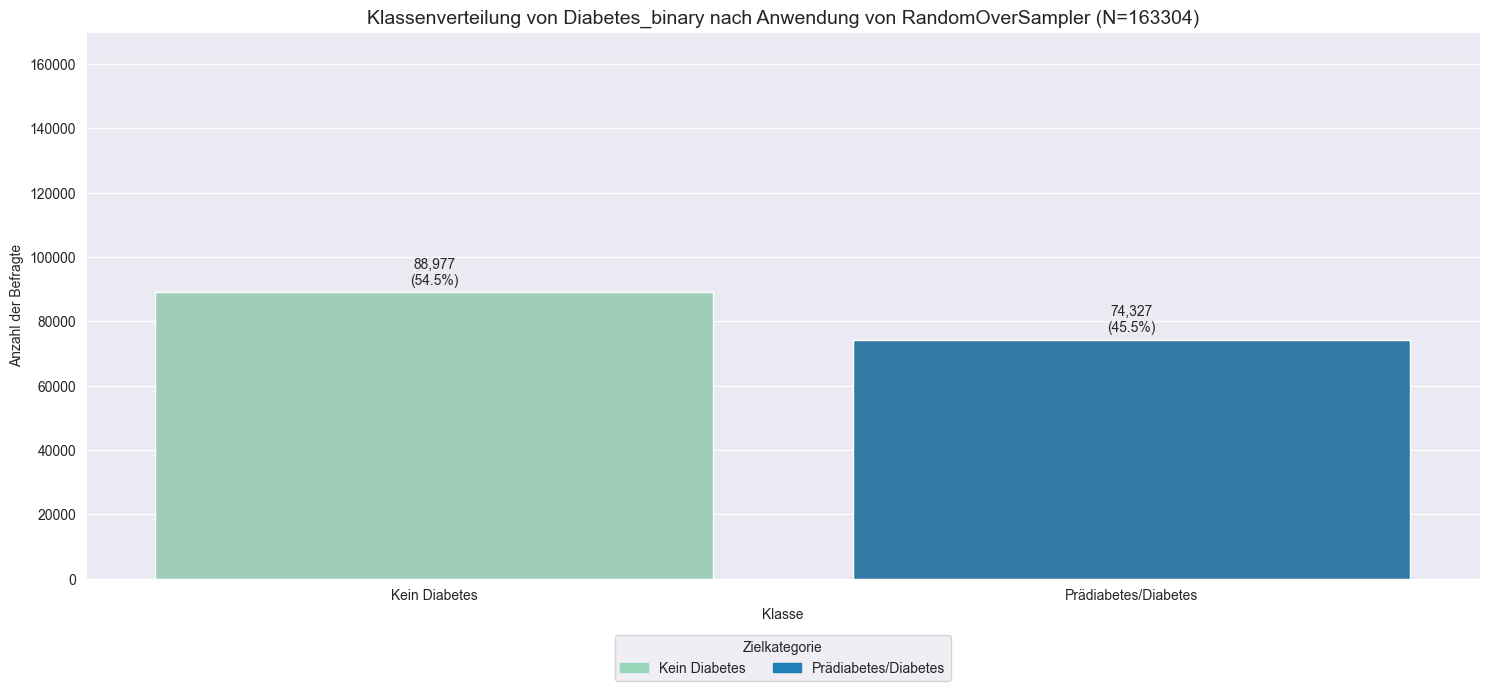

In [253]:
# E_R_1: Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_ros, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary nach Anwendung von RandomOverSampler (N=163304)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_ros) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_ros)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [254]:
# E_R_1: Performancebewertung
lr_ros = LogisticRegression(random_state=42, max_iter=1000)
lr_ros.fit(X_ros, np.ravel(y_ros))

y_pred_ros = lr_ros.predict(X_test)
y_proba_ros = lr_ros.predict_proba(X_test)[:,1]

roc_auc_ros = roc_auc_score(np.ravel(y_test), y_proba_ros)

print("E_R_1")
print(f"ROC AUC:   {roc_auc_ros:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred_ros))
print(confusion_matrix(np.ravel(y_test), y_pred_ros))

E_R_1
ROC AUC:   0.819

              precision    recall  f1-score   support

           0       0.94      0.78      0.85     43667
           1       0.34      0.70      0.45      7069

    accuracy                           0.77     50736
   macro avg       0.64      0.74      0.65     50736
weighted avg       0.86      0.77      0.80     50736

[[33925  9742]
 [ 2119  4950]]


In [255]:
# E_R_2: Oversampling mit SMOTENC auf Minderheitklasse
categorical_features_name = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
categorical_index = [X_train.columns.get_loc(i) for i in categorical_features_name]

snc = SMOTENC(categorical_features=categorical_index, sampling_strategy='minority', random_state=42)

X_snc, y_snc = snc.fit_resample(X_train, y_train)

X_snc = pd.DataFrame(X_snc, columns=X_train.columns, index=X_train.index)
y_snc = pd.DataFrame(y_snc, columns=y_train.columns, index=y_train.index)

print("Nach SMOTENC: ", y_snc.value_counts())

Nach SMOTENC:  Diabetes_binary
0                  88977
1                  74327
Name: count, dtype: int64


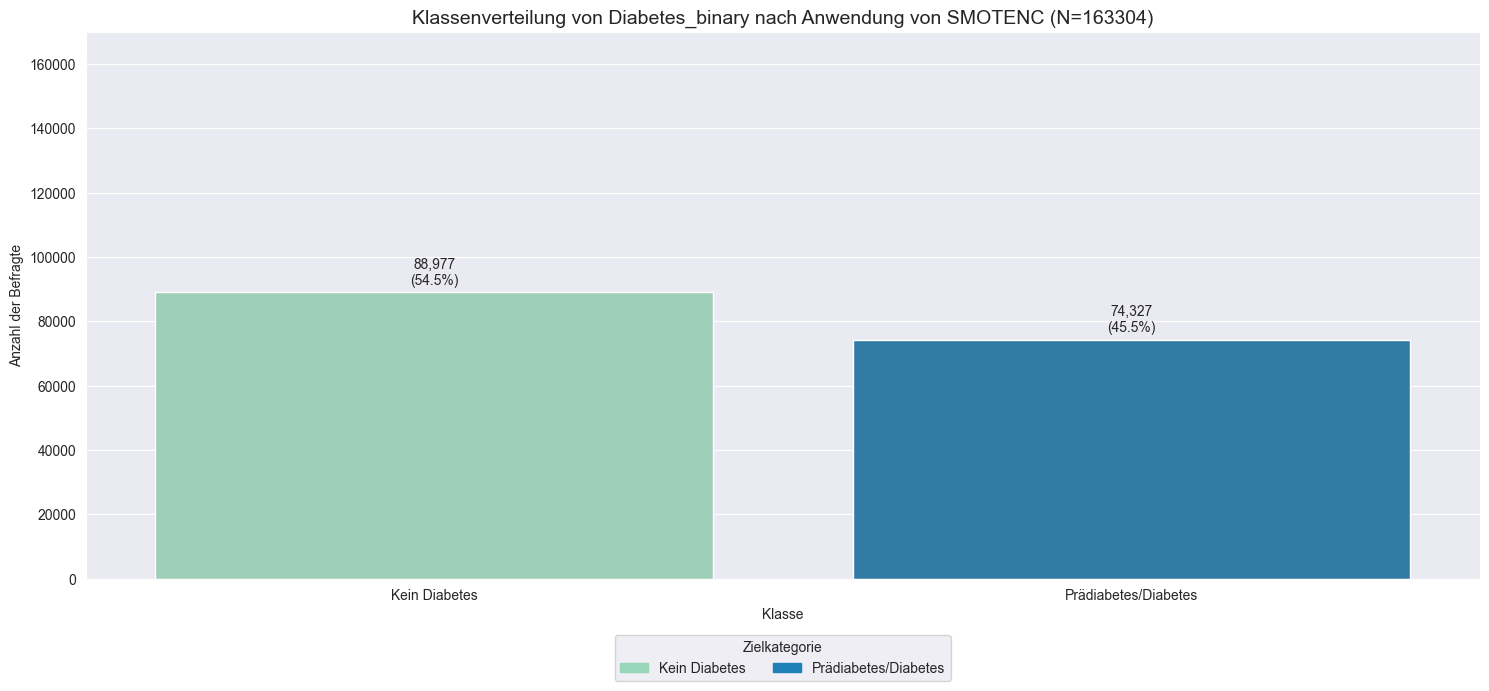

In [257]:
# E_R_2: Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_snc, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary nach Anwendung von SMOTENC (N=163304)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_snc) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_snc)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [258]:
# E_R_2: Performancebewertung
lr_snc = LogisticRegression(random_state=42, max_iter=1000)
lr_snc.fit(X_snc, np.ravel(y_snc))

y_pred_snc = lr_snc.predict(X_test)
y_proba_snc = lr_snc.predict_proba(X_test)[:,1]

roc_auc_snc = roc_auc_score(np.ravel(y_test), y_proba_snc)

print("E_R_2")
print(f"ROC AUC:   {roc_auc_snc:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred_snc))
print(confusion_matrix(np.ravel(y_test), y_pred_snc))

E_R_2
ROC AUC:   0.807

              precision    recall  f1-score   support

           0       0.94      0.77      0.85     43667
           1       0.33      0.68      0.44      7069

    accuracy                           0.76     50736
   macro avg       0.63      0.73      0.64     50736
weighted avg       0.85      0.76      0.79     50736

[[33680  9987]
 [ 2233  4836]]


In [259]:
# E_R_3: Undersamplung mit RandomUnderSampler auf Majorityklasse
rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')

X_rus, y_rus = rus.fit_resample(X_train, y_train)

X_rus = X_rus.reset_index(drop=True)
y_rus = y_rus.reset_index(drop=True)

print("Nach Random Under Sampling: ", y_rus.value_counts())

Nach Random Under Sampling:  Diabetes_binary
0                  24633
1                  24633
Name: count, dtype: int64


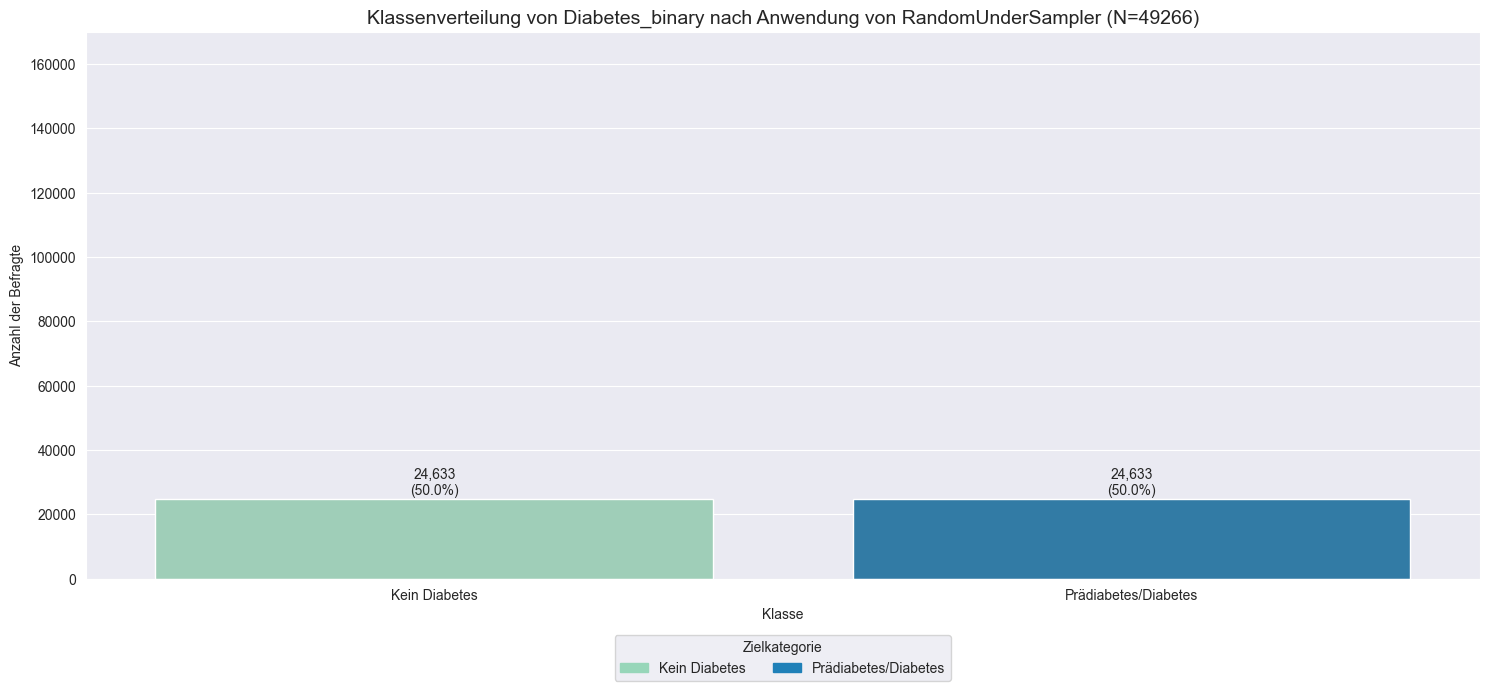

In [260]:
# E_R_3: Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_rus, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary nach Anwendung von RandomUnderSampler (N=49266)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_rus) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_rus)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [261]:
# E_R_3: Performancebewertung
lr_rus = LogisticRegression(random_state=42, max_iter=1000)
lr_rus.fit(X_rus, np.ravel(y_rus))

y_pred_rus = lr_rus.predict(X_test)
y_proba_rus = lr_rus.predict_proba(X_test)[:,1]

roc_auc_rus = roc_auc_score(np.ravel(y_test), y_proba_rus)

print("E_R_3")
print(f"ROC AUC:   {roc_auc_rus:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred_rus))
print(confusion_matrix(np.ravel(y_test), y_pred_rus))

E_R_3
ROC AUC:   0.819

              precision    recall  f1-score   support

           0       0.95      0.74      0.83     43667
           1       0.31      0.75      0.44      7069

    accuracy                           0.74     50736
   macro avg       0.63      0.74      0.64     50736
weighted avg       0.86      0.74      0.77     50736

[[32132 11535]
 [ 1776  5293]]


In [262]:
# E_R_4: Undersampling mit EEN auf Majority
enn = EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=3, kind_sel='all')

X_enn, y_enn = enn.fit_resample(X_train, y_train)

X_enn = X_enn.reset_index(drop=True)
y_enn = y_enn.reset_index(drop=True)

print("Nach ENN: ", y_enn.value_counts())

Nach ENN:  Diabetes_binary
0                  97949
1                  24633
Name: count, dtype: int64


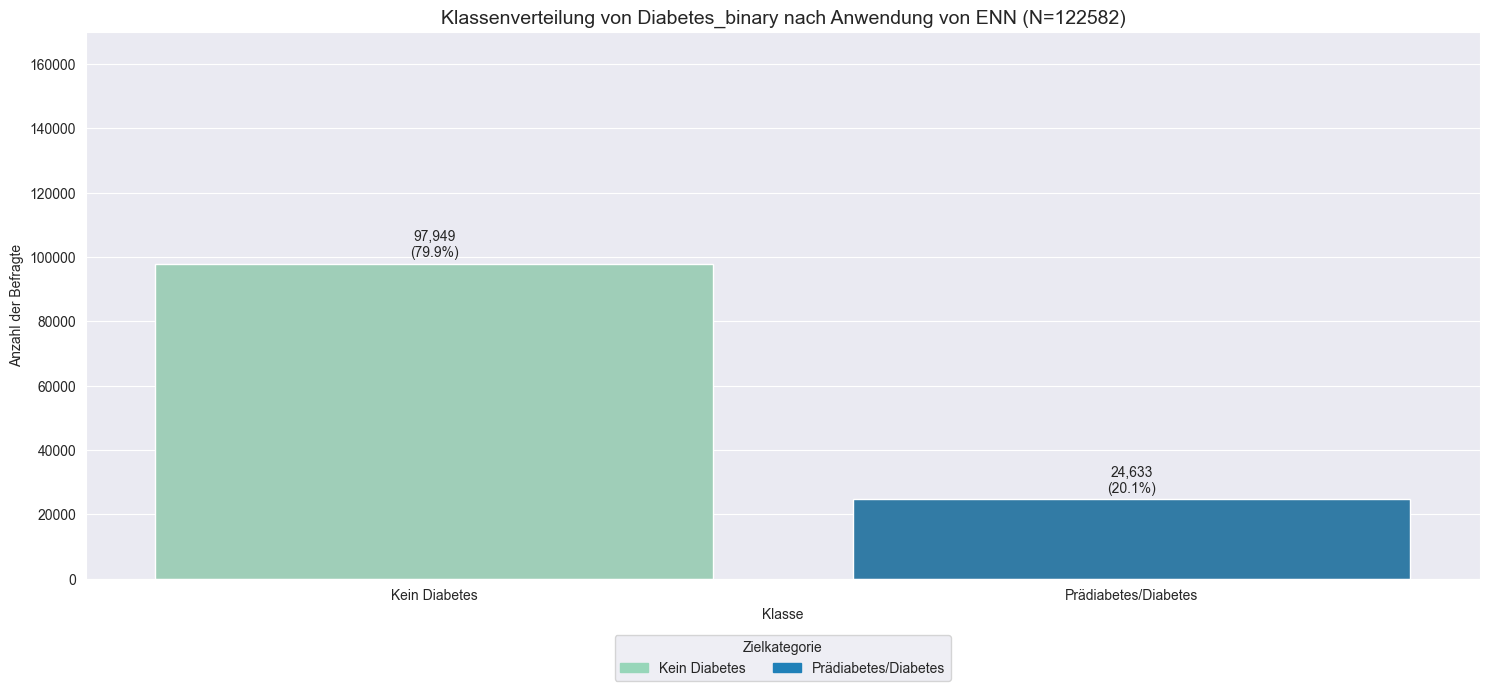

In [263]:
# E_R_4: Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_enn, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary nach Anwendung von ENN (N=122582)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_enn) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_enn)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [264]:
# E_R_4: Performancebewertung
lr_enn = LogisticRegression(random_state=42, max_iter=1000)
lr_enn.fit(X_enn, np.ravel(y_enn))

y_pred_enn = lr_enn.predict(X_test)
y_proba_enn = lr_enn.predict_proba(X_test)[:,1]

roc_auc_enn = roc_auc_score(np.ravel(y_test), y_proba_enn)

print("E_R_4")
print(f"ROC AUC:   {roc_auc_enn:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred_enn))
print(confusion_matrix(np.ravel(y_test), y_pred_enn))

E_R_4
ROC AUC:   0.820

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     43667
           1       0.40      0.49      0.44      7069

    accuracy                           0.83     50736
   macro avg       0.66      0.69      0.67     50736
weighted avg       0.84      0.83      0.83     50736

[[38529  5138]
 [ 3599  3470]]


In [265]:
# E_R_5: Undersampling mit NearMiss auf Majorityklasse
nm = NearMiss(version=1, n_neighbors=3, sampling_strategy='majority')

X_nm, y_nm = nm.fit_resample(X_train, y_train)

X_nm = X_nm.reset_index(drop=True)
y_nm = y_nm.reset_index(drop=True)

print("Nach NearMiss: ", y_nm.value_counts())

Nach NearMiss:  Diabetes_binary
0                  24633
1                  24633
Name: count, dtype: int64


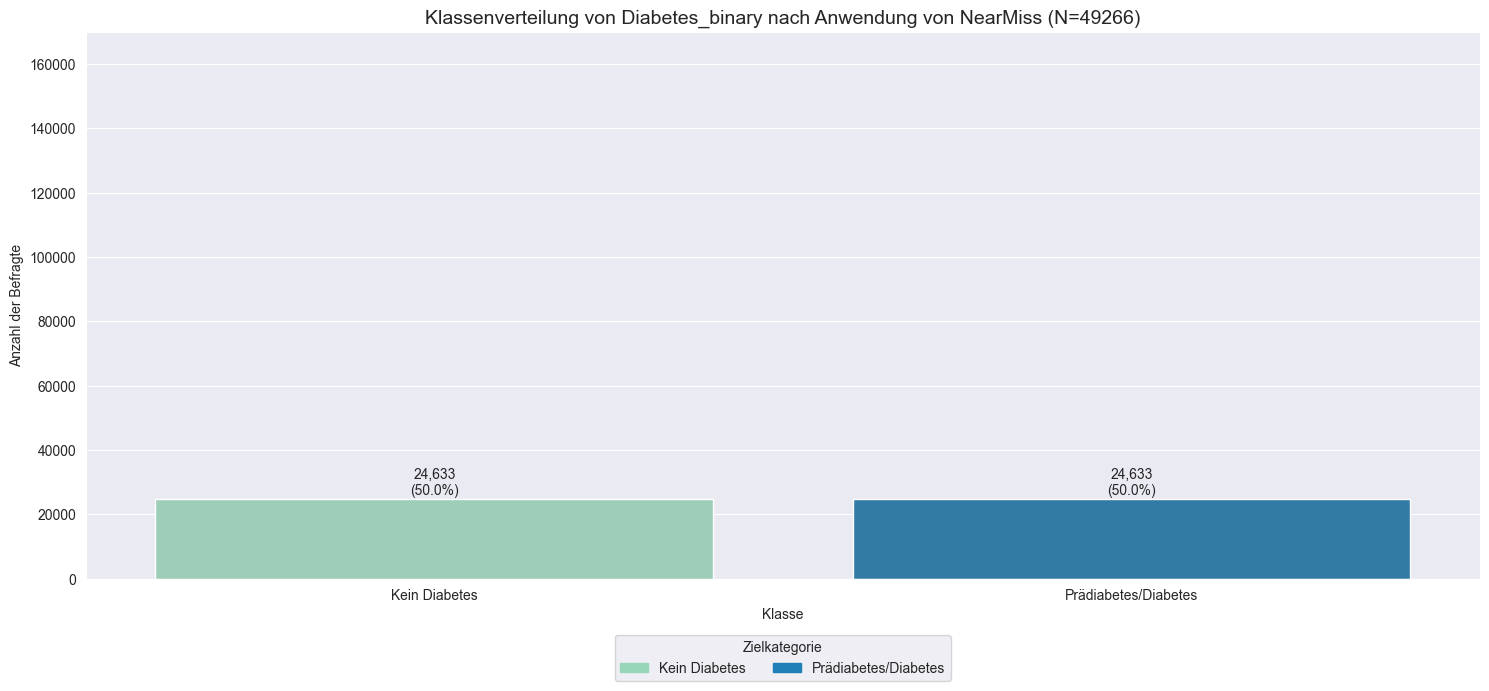

In [266]:
# E_R_5: Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_nm, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary nach Anwendung von NearMiss (N=49266)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_nm) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_nm)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [267]:
# E_R_5: Performancebewertung
lr_nm = LogisticRegression(random_state=42, max_iter=1000)
lr_nm.fit(X_nm, np.ravel(y_nm))

y_pred_nm = lr_nm.predict(X_test)
y_proba_nm = lr_nm.predict_proba(X_test)[:,1]

roc_auc_nm = roc_auc_score(np.ravel(y_test), y_proba_nm)

print("E_R_5")
print(f"ROC AUC:   {roc_auc_nm:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred_nm))
print(confusion_matrix(np.ravel(y_test), y_pred_nm))

E_R_5
ROC AUC:   0.690

              precision    recall  f1-score   support

           0       0.93      0.52      0.67     43667
           1       0.21      0.77      0.32      7069

    accuracy                           0.56     50736
   macro avg       0.57      0.64      0.50     50736
weighted avg       0.83      0.56      0.62     50736

[[22849 20818]
 [ 1660  5409]]


In [268]:
# E_R_6: Underampling mit TomekLinks
tl = TomekLinks(sampling_strategy='all')

X_tl, y_tl = tl.fit_resample(X_train, y_train)

X_tl = X_tl.reset_index(drop=True)
y_tl = y_tl.reset_index(drop=True)

print("Nach TomekLinks: ", y_tl.value_counts())

Nach TomekLinks:  Diabetes_binary
0                  132751
1                   18713
Name: count, dtype: int64


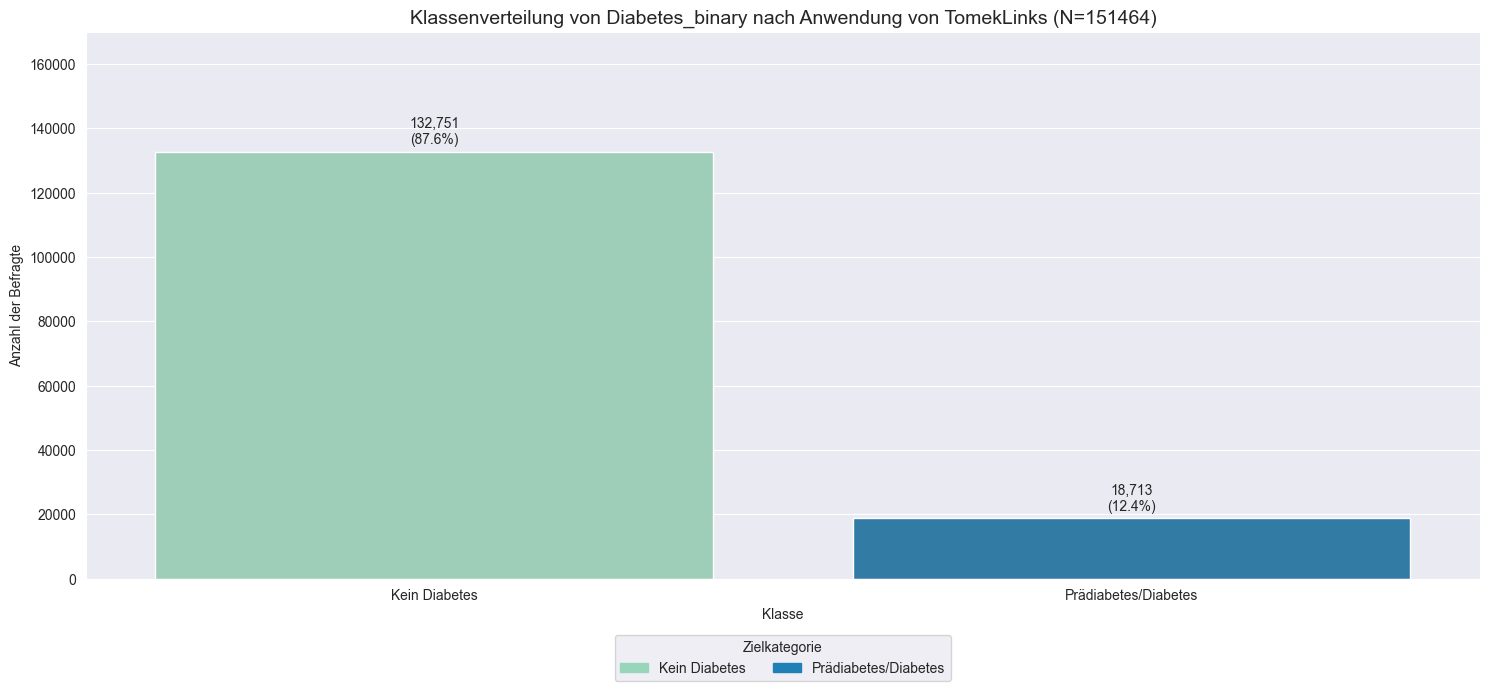

In [269]:
# E_R_6: Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_tl, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary nach Anwendung von TomekLinks (N=151464)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_tl) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_tl)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [270]:
# E_R_6: Performancebewertung
lr_tl = LogisticRegression(random_state=42, max_iter=1000)
lr_tl.fit(X_tl, np.ravel(y_tl))

y_pred_tl = lr_tl.predict(X_test)
y_proba_tl = lr_tl.predict_proba(X_test)[:,1]

roc_auc_tl = roc_auc_score(np.ravel(y_test), y_proba_tl)

print("E_R_6")
print(f"ROC AUC:   {roc_auc_tl:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred_tl))
print(confusion_matrix(np.ravel(y_test), y_pred_tl))

E_R_6
ROC AUC:   0.819

              precision    recall  f1-score   support

           0       0.88      0.98      0.92     43667
           1       0.53      0.14      0.22      7069

    accuracy                           0.86     50736
   macro avg       0.70      0.56      0.57     50736
weighted avg       0.83      0.86      0.83     50736

[[42810   857]
 [ 6111   958]]


In [271]:
# E_R_7: Kombination von SMOTENC und ENN
categorical_features_name = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
categorical_index = [X_train.columns.get_loc(i) for i in categorical_features_name]
snc = SMOTENC(categorical_features=categorical_index)

senn = SMOTEENN(sampling_strategy='all', random_state=42, smote=snc, enn=EditedNearestNeighbours())

X_senn, y_senn = senn.fit_resample(X_train, y_train)

X_senn = X_senn.reset_index(drop=True)
y_senn = y_senn.reset_index(drop=True)

print("Nach SMOTENC+ENN: ", y_senn.value_counts())

Nach SMOTENC+ENN:  Diabetes_binary
0                  138671
1                   97743
Name: count, dtype: int64


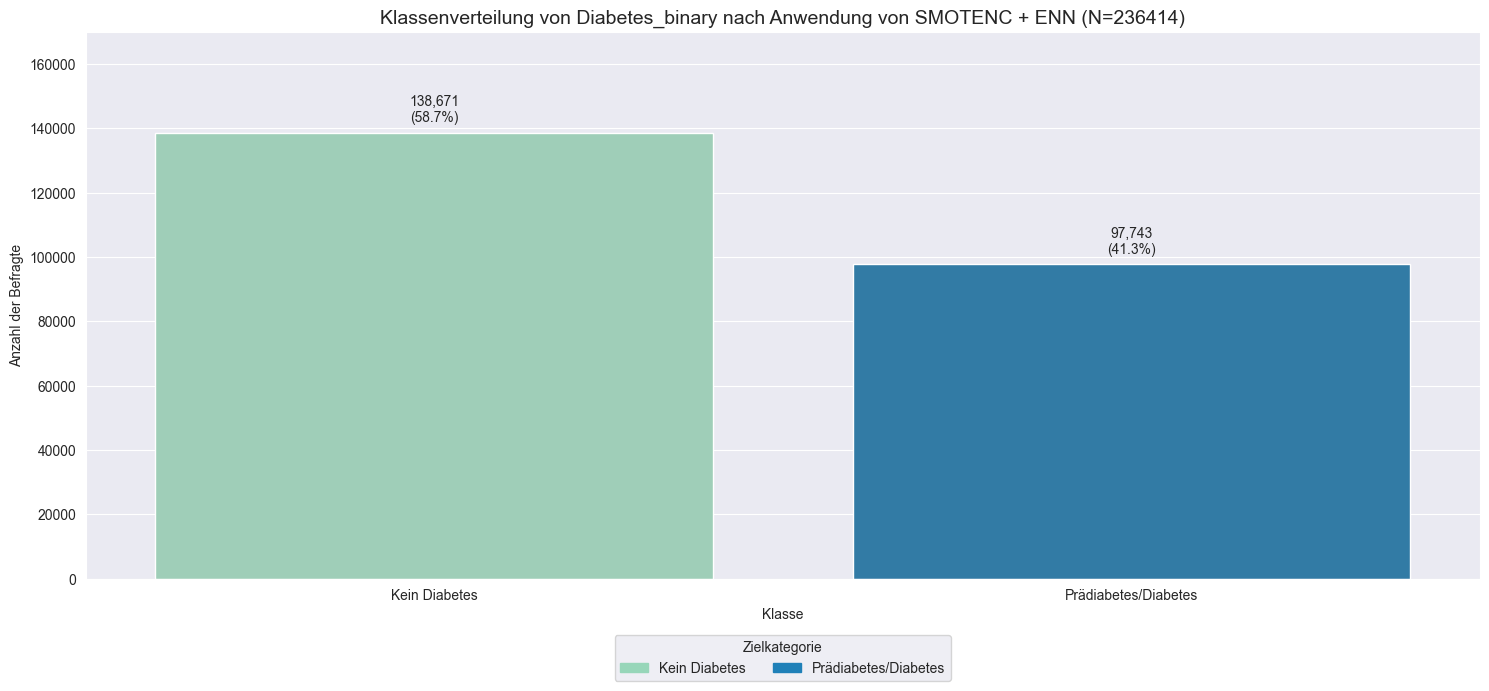

In [272]:
# E_R_7: Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_senn, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary nach Anwendung von SMOTENC + ENN (N=236414)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_senn) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_senn)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [274]:
# E_R_7: Performancebewertung
lr_senn = LogisticRegression(random_state=42, max_iter=1000)
lr_senn.fit(X_senn, np.ravel(y_senn))

y_pred_senn = lr_senn.predict(X_test)
y_proba_senn = lr_senn.predict_proba(X_test)[:,1]

roc_auc_senn = roc_auc_score(np.ravel(y_test), y_proba_senn)

print("E_R_7")
print(f"ROC AUC:   {roc_auc_senn:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred_senn))
print(confusion_matrix(np.ravel(y_test), y_pred_senn))

E_R_7
ROC AUC:   0.807

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     43667
           1       0.35      0.60      0.44      7069

    accuracy                           0.79     50736
   macro avg       0.64      0.71      0.66     50736
weighted avg       0.85      0.79      0.81     50736

[[35753  7914]
 [ 2801  4268]]


In [8]:
# E_R_8: Kombination von SMOTENC und TomekLinks
categorical_features_name = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
categorical_index = [X_train.columns.get_loc(i) for i in categorical_features_name]
snc = SMOTENC(categorical_features=categorical_index)

stm = SMOTETomek(sampling_strategy='all', random_state=42, smote=snc, tomek=TomekLinks())

X_stm, y_stm = stm.fit_resample(X_train, y_train)
X_stm = X_stm.reset_index(drop=True)
y_stm = y_stm.reset_index(drop=True)

print("Nach SMOTENC+Tomek: ", y_stm.value_counts())

Nach SMOTENC+Tomek:  Diabetes_binary
0                  138671
1                  134523
Name: count, dtype: int64


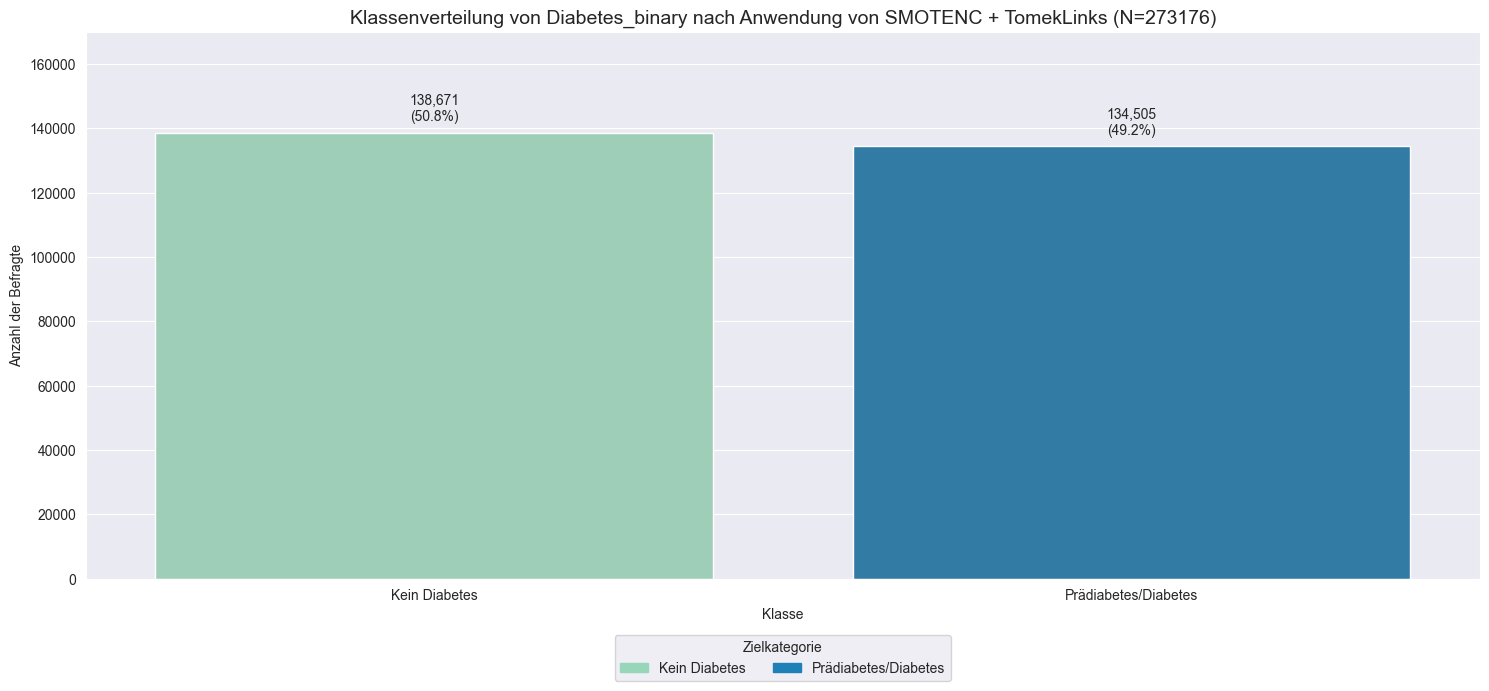

In [276]:
# E_R_8: Plot Klassenverteilung von Zielvariable
colors = sns.color_palette("YlGnBu", n_colors=2)
target_labels = {0: 'Kein Diabetes', 1: 'Prädiabetes/Diabetes'}

# Plot
plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Diabetes_binary', data=y_stm, palette=colors, hue='Diabetes_binary', legend=False)
plt.title('Klassenverteilung von Diabetes_binary nach Anwendung von SMOTENC + TomekLinks (N=273176)', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels([target_labels[i] for i in [0, 1]])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Befragte')
plt.ylim(0,170000)

# Werte über Balken
for p in ax.patches:
    count = int(p.get_height())
    pct = count / len(X_stm) * 100
    ax.text(p.get_x() + p.get_width() / 2,
            count + len(X_stm)*0.01,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom')

# Legende manuell hinzufügen
legend_handles = [Patch(color=c, label=target_labels[i]) for i, c in zip([0, 1], colors)]
plt.legend(handles=legend_handles, title='Zielkategorie', loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [9]:
# E_R_8: Performancebewertung
lr_stm = LogisticRegression(random_state=42, max_iter=1000)
lr_stm.fit(X_stm, np.ravel(y_stm))

y_pred_stm = lr_stm.predict(X_test)
y_proba_stm = lr_stm.predict_proba(X_test)[:,1]

roc_auc_stm = roc_auc_score(np.ravel(y_test), y_proba_stm)

print("E_R_8")
print(f"ROC AUC:   {roc_auc_stm:.3f}\n")

print(classification_report(np.ravel(y_test), y_pred_stm))
print(confusion_matrix(np.ravel(y_test), y_pred_stm))

E_R_8
ROC AUC:   0.806

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     43667
           1       0.31      0.72      0.44      7069

    accuracy                           0.74     50736
   macro avg       0.63      0.73      0.63     50736
weighted avg       0.86      0.74      0.78     50736

[[32467 11200]
 [ 1964  5105]]


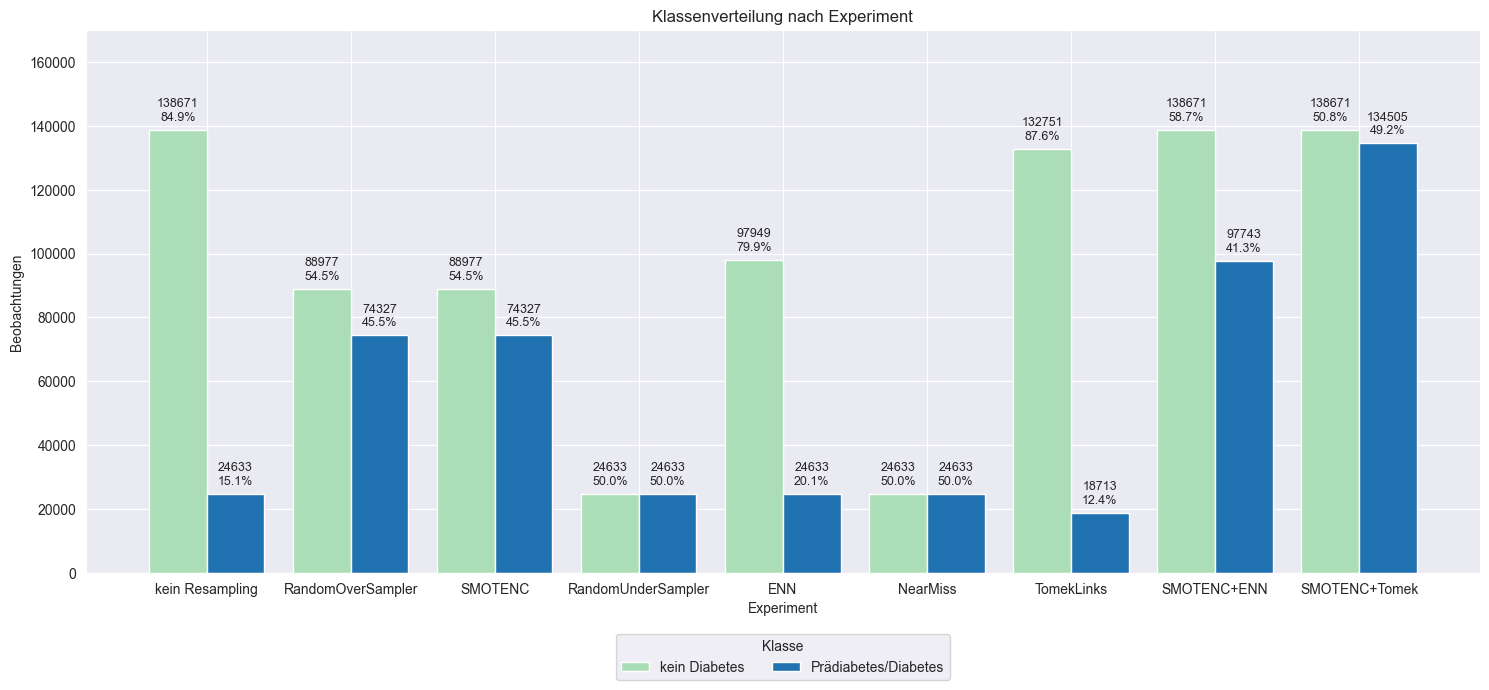

In [278]:
# Vorbereitung für Vergleich
data1 = {
    'Experiment': ['kein Resampling', 'RandomOverSampler', 'SMOTENC', 'RandomUnderSampler', 'ENN', 'NearMiss', 'TomekLinks', 'SMOTENC+ENN', 'SMOTENC+Tomek'],
    'kein Diabetes': [138671,88977,88977,24633,97949,24633,132751,138671,138671],
    'Prädiabetes/Diabetes': [24633,74327,74327,24633,24633,24633,18713,97743,134505]
}
df = pd.DataFrame(data1).set_index('Experiment')

# 2. Farben aus YlGnBu‑Palette
cmap = plt.get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.7, df.shape[1]))

# 3. Plot-Setup
num_groups = df.shape[0]
num_classes = df.shape[1]
bar_width = 0.8 / num_classes
indices = np.arange(num_groups)

fig, ax = plt.subplots(figsize=(15, 7))

# 4. Balken zeichnen und Bar-Container sammeln
bar_containers = []
for j, klasse in enumerate(df.columns):
    x = indices - 0.4 + j * bar_width
    bc = ax.bar(x, df[klasse].values, width=bar_width, color=colors[j], label=klasse)
    bar_containers.append(bc)

# 5. Achsen, Titel & Legende
ax.set_xticks(indices - 0.4 + bar_width * (num_classes / 2 - 0.5))
ax.set_xticklabels(df.index, rotation=0)
ax.set_xlabel('Experiment')
ax.set_ylabel('Beobachtungen')
ax.set_title('Klassenverteilung nach Experiment')
ax.set_ylim(0, 170000)
ax.legend(
    title='Klasse',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=2
)

# 6. Beschriftungen absolut + relativ exakt mittig auf jedem Balken
for bc in bar_containers:
    for bar in bc:
        height = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        # total für das jeweilige Experiment:
        idx = int(round(x_center))
        total = df.iloc[idx].sum()
        rel = height / total
        ax.text(
            x_center, height + 2000,
            f"{int(height)}\n{rel:.1%}",
            ha='center', va='bottom', fontsize=9
        )

plt.tight_layout()
plt.show()

fig.savefig(
    "klassen_verteilung.png",
    dpi=300,
    bbox_inches='tight',
    format='png',
    facecolor='w'
)

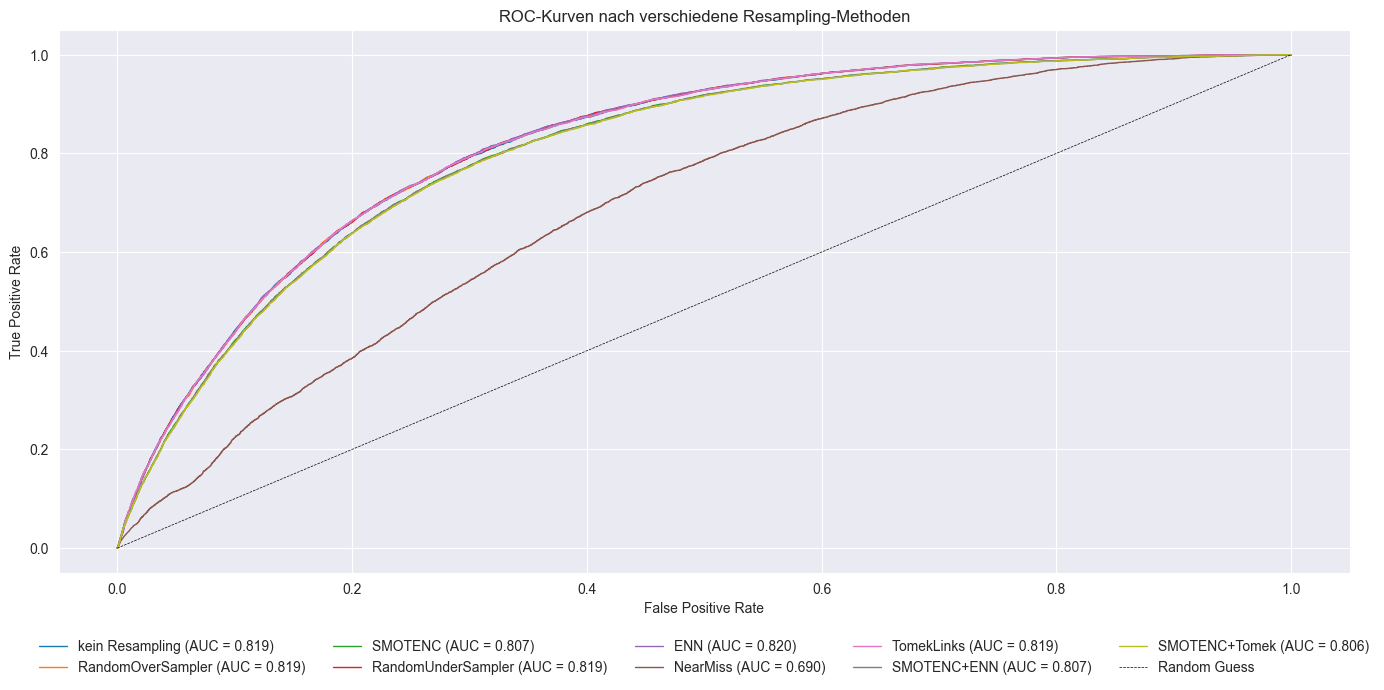

In [281]:
# ROC-AUC
y_scores_dict = {
    'kein Resampling': y_proba,
    'RandomOverSampler': y_proba_ros,
    'SMOTENC': y_proba_snc,
    'RandomUnderSampler': y_proba_rus,
    'ENN': y_proba_enn,
    'NearMiss': y_proba_nm,
    'TomekLinks': y_proba_tl,
    'SMOTENC+ENN': y_proba_senn,
    'SMOTENC+Tomek': y_proba_stm
}

fig = plt.figure(figsize=(15, 7))

for name, scores in y_scores_dict.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc1 = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc1:.3f})", lw=1)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurven nach verschiedene Resampling-Methoden')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=5,
    frameon=False
)

plt.tight_layout()
plt.show()

fig.savefig(
    "roc.png",
    dpi=300,
    bbox_inches='tight',
    format='png',
    facecolor='w'
)

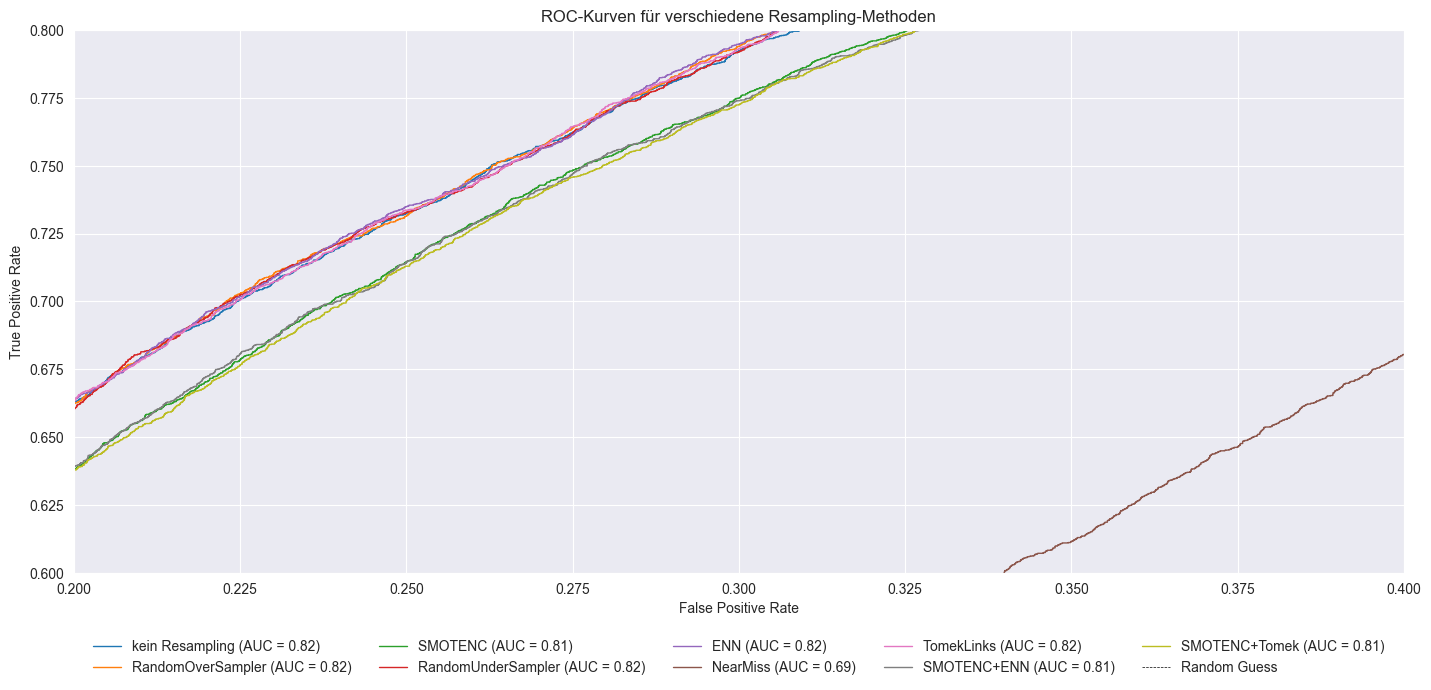

In [282]:
# ROC-AUC
y_scores_dict = {
    'kein Resampling': y_proba,
    'RandomOverSampler': y_proba_ros,
    'SMOTENC': y_proba_snc,
    'RandomUnderSampler': y_proba_rus,
    'ENN': y_proba_enn,
    'NearMiss': y_proba_nm,
    'TomekLinks': y_proba_tl,
    'SMOTENC+ENN': y_proba_senn,
    'SMOTENC+Tomek': y_proba_stm
}

plt.figure(figsize=(15, 7))

for name, scores in y_scores_dict.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc1 = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc1:.2f})", lw=1)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurven für verschiedene Resampling-Methoden')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=5,
    frameon=False
)
plt.xlim(0.2, 0.4)
plt.ylim(0.6, 0.8)

plt.tight_layout()
plt.show()

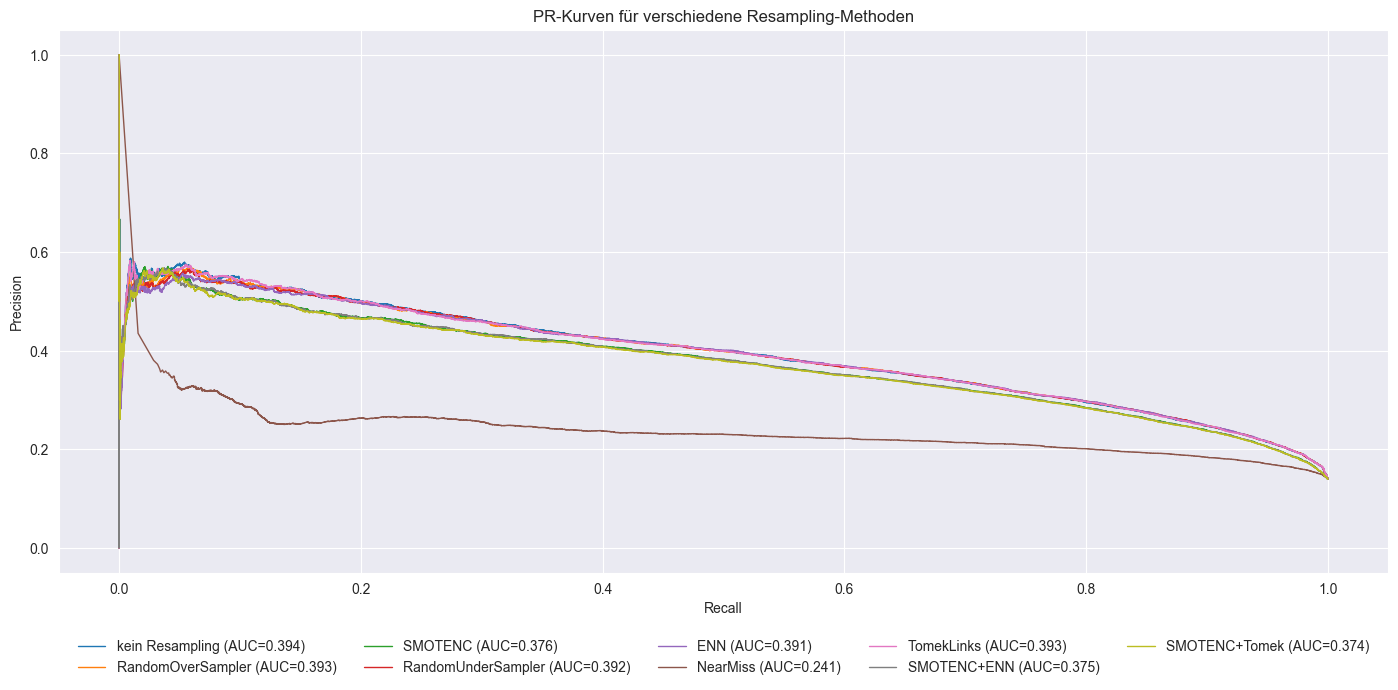

In [283]:
# PR-AUC
y_score_dict = {
    'kein Resampling': y_proba,
    'RandomOverSampler': y_proba_ros,
    'SMOTENC': y_proba_snc,
    'RandomUnderSampler': y_proba_rus,
    'ENN': y_proba_enn,
    'NearMiss': y_proba_nm,
    'TomekLinks': y_proba_tl,
    'SMOTENC+ENN': y_proba_senn,
    'SMOTENC+Tomek': y_proba_stm
}

fig = plt.figure(figsize=(15, 7))

for name, y_scores in y_score_dict.items():
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.3f})", linewidth=1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-Kurven für verschiedene Resampling-Methoden')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=5,
    frameon=False
)

plt.tight_layout()
plt.show()

fig.savefig(
    "pr.png",
    dpi=300,
    bbox_inches='tight',
    format='png',
    facecolor='w'
)

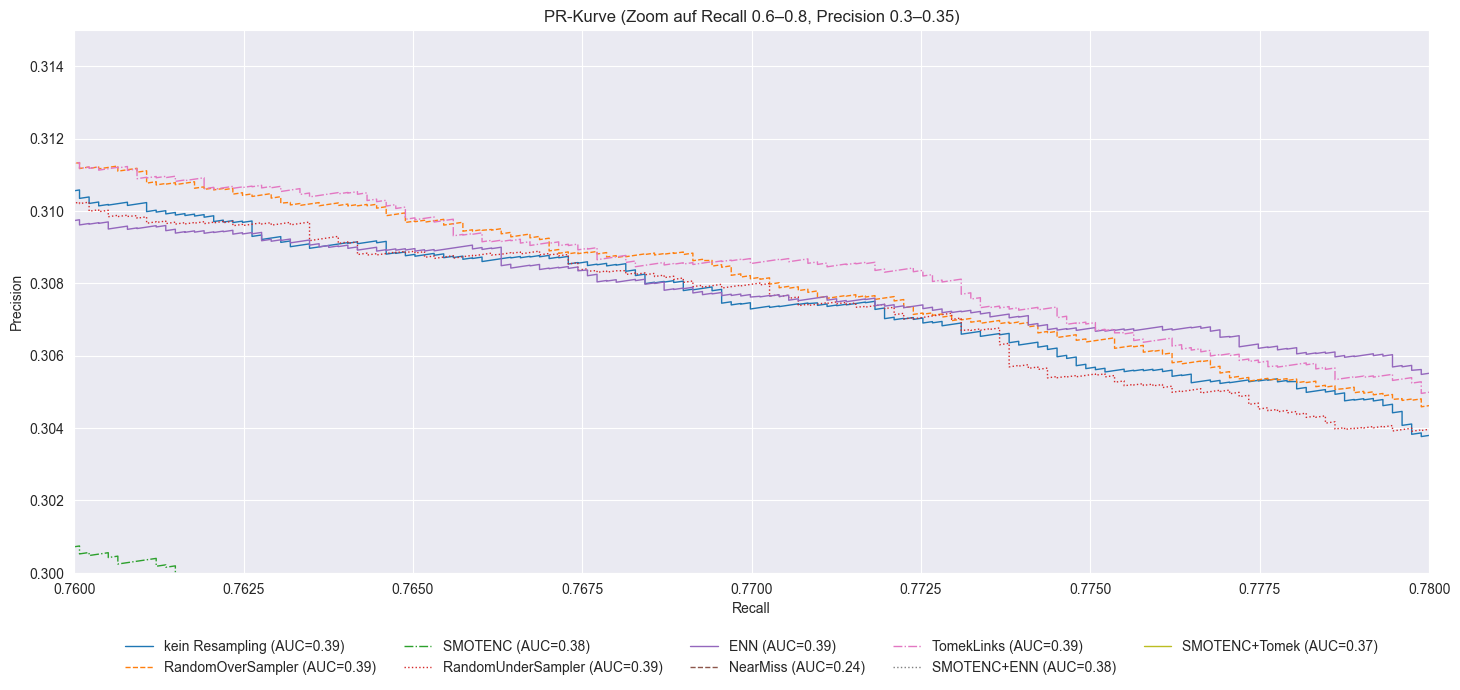

In [284]:
# PR-AUC
y_score_dict = {
    'kein Resampling': y_proba,
    'RandomOverSampler': y_proba_ros,
    'SMOTENC': y_proba_snc,
    'RandomUnderSampler': y_proba_rus,
    'ENN': y_proba_enn,
    'NearMiss': y_proba_nm,
    'TomekLinks': y_proba_tl,
    'SMOTENC+ENN': y_proba_senn,
    'SMOTENC+Tomek': y_proba_stm
}

plt.figure(figsize=(15, 7))

# Farben & Plot-Stil
colors = plt.get_cmap('tab10').colors
linestyles = ['solid', 'dashed', 'dashdot', 'dotted'] * 3  # falls mehr als 4 Methoden

for (i, (name, y_scores)) in enumerate(y_score_dict.items()):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    plt.plot(
        recall, precision,
        label=f"{name} (AUC={pr_auc:.2f})",
        linewidth=1,
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)]
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-Kurve (Zoom auf Recall 0.6–0.8, Precision 0.3–0.35)')

plt.xlim(0.76, 0.78)
plt.ylim(0.30, 0.3150)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=5,
    frameon=False
)

plt.tight_layout()
plt.show()

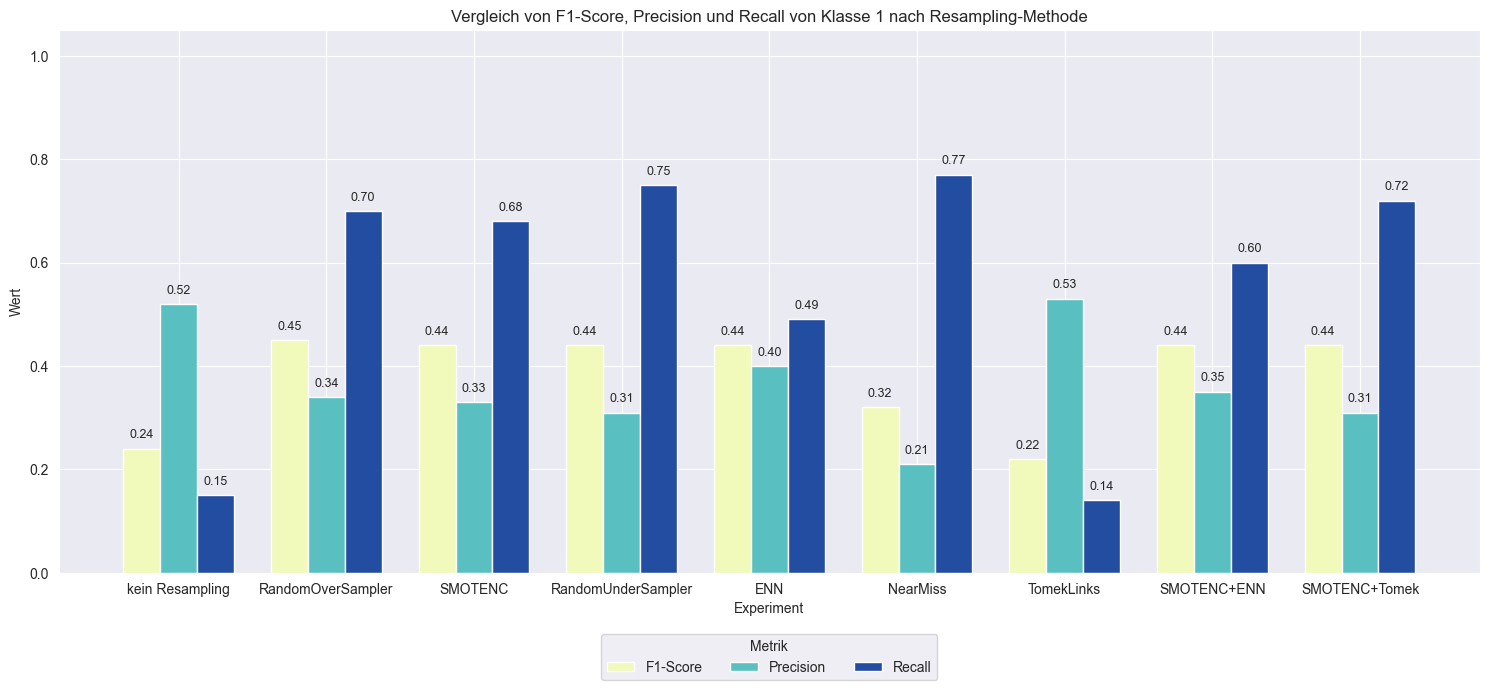

In [285]:
# Group: F1, Pr, R
data_metrics = {
    'Experiment': [
        'kein Resampling', 'RandomOverSampler', 'SMOTENC',
        'RandomUnderSampler', 'ENN', 'NearMiss', 'TomekLinks',
        'SMOTENC+ENN', 'SMOTENC+Tomek'
    ],
    'F1-Score':     [0.24, 0.45, 0.44, 0.44, 0.44, 0.32, 0.22, 0.44, 0.44],
    'Precision':    [0.52, 0.34, 0.33, 0.31, 0.40, 0.21, 0.53, 0.35, 0.31],
    'Recall':       [0.15, 0.70, 0.68, 0.75, 0.49, 0.77, 0.14, 0.60, 0.72]
}
df = pd.DataFrame(data_metrics)

# Umstrukturieren für grouped barplot
df_melted = df.melt(id_vars='Experiment', var_name='Metrik', value_name='Wert')
metriken = ['F1-Score', 'Precision', 'Recall']

# Balkenfarben aus YlGnBu
cmap = plt.get_cmap('YlGnBu')
colors = cmap(np.linspace(0.1, 0.8, len(metriken)))

# Balkenparameter
bar_width = 0.25
x = np.arange(len(df['Experiment']))

# Plot
fig, ax = plt.subplots(figsize=(15, 7))

# Für jede Metrik gruppierte Balken plotten
for i, metrik in enumerate(metriken):
    werte = df[metrik]
    xpos = x + i * bar_width
    bars = ax.bar(xpos, werte, width=bar_width, color=colors[i], label=metrik)

    # Beschriftung mittig über jedem Balken
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

# Achsen, Titel, Beschriftung
ax.set_xticks(x + bar_width)
ax.set_xticklabels(df['Experiment'], rotation=0)
ax.set_xlabel('Experiment')
ax.set_ylabel('Wert')
ax.set_title('Vergleich von F1-Score, Precision und Recall von Klasse 1 nach Resampling-Methode')
ax.set_ylim(0, 1.05)

# Legende unterhalb des Plots
ax.legend(
    title='Metrik',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3
)

fig.savefig(
    "vergleich_metric.png",
    dpi=300,
    bbox_inches='tight',
    format='png',
    facecolor='w'
)

plt.tight_layout()
plt.show()

In [286]:
# Skalierung
numeric_cols = ["BMI", "MentHlth", "PhysHlth"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
    ],
    remainder="passthrough"
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
])

X_train_scaled = pipe.fit_transform(X_train)
X_val_scaled   = pipe.transform(X_val)
X_test_scaled  = pipe.transform(X_test)

rest_cols = [c for c in X_train.columns if c not in numeric_cols]
new_columns = numeric_cols + rest_cols

X_train_scaled = pd.DataFrame(X_train_scaled, columns=new_columns, index=X_train.index)
X_val_scaled   = pd.DataFrame(X_val_scaled,   columns=new_columns, index=X_val.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=new_columns, index=X_test.index)

X_train = X_train_scaled
X_val = X_val_scaled
X_test = X_test_scaled

In [287]:
# Datensatz speichern
X_train.to_csv("X_train.csv")
X_val.to_csv("X_val.csv")
X_test.to_csv("X_test.csv")

y_train.to_csv("y_train.csv")
y_val.to_csv("y_val.csv")
y_test.to_csv("y_test.csv")

In [291]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (163304, 21)
X_val shape: (25368, 21)
X_test shape: (50736, 21)
y_train shape: (163304, 1)
y_val shape: (25368, 1)
y_test shape: (50736, 1)


In [288]:
# Skalierung resampelten Daten
numeric_cols = ["BMI", "MentHlth", "PhysHlth"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
    ],
    remainder="passthrough"
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
])

X_train_scaled_ros = pipe.fit_transform(X_ros)
X_val_scaled_ros   = pipe.transform(X_val)
X_test_scaled_ros  = pipe.transform(X_test)

rest_cols = [c for c in X_ros.columns if c not in numeric_cols]
new_columns = numeric_cols + rest_cols

X_train_scaled_ros = pd.DataFrame(X_train_scaled_ros, columns=new_columns, index=X_ros.index)
X_val_scaled_ros   = pd.DataFrame(X_val_scaled_ros,   columns=new_columns, index=X_val.index)
X_test_scaled_ros  = pd.DataFrame(X_test_scaled_ros,  columns=new_columns, index=X_test.index)

X_train_ros = X_train_scaled_ros
X_val_ros = X_val_scaled_ros
X_test_ros = X_test_scaled_ros

In [289]:
# Datensatz speichern
X_train_ros.to_csv("X_train_ros.csv")
X_val_ros.to_csv("X_val_ros.csv")
X_test_ros.to_csv("X_test_ros.csv")

y_ros.to_csv("y_train_ros.csv")

In [290]:
print("X_train_ros shape:", X_train_ros.shape)
print("X_val_ros shape:", X_val_ros.shape)
print("X_test_ros shape:", X_test_ros.shape)

print("y_train_ros shape:", y_ros.shape)

X_train_ros shape: (163304, 21)
X_val_ros shape: (25368, 21)
X_test_ros shape: (50736, 21)
y_train_ros shape: (163304, 1)


In [10]:
# Skalierung resampelten Daten
numeric_cols = ["BMI", "MentHlth", "PhysHlth"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
    ],
    remainder="passthrough"
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
])

X_train_scaled_stm = pipe.fit_transform(X_stm)
X_val_scaled_stm   = pipe.transform(X_val)
X_test_scaled_stm  = pipe.transform(X_test)

rest_cols = [c for c in X_stm.columns if c not in numeric_cols]
new_columns = numeric_cols + rest_cols

X_train_scaled_stm = pd.DataFrame(X_train_scaled_stm, columns=new_columns, index=X_stm.index)
X_val_scaled_stm   = pd.DataFrame(X_val_scaled_stm,   columns=new_columns, index=X_val.index)
X_test_scaled_stm  = pd.DataFrame(X_test_scaled_stm,  columns=new_columns, index=X_test.index)

X_train_stm = X_train_scaled_stm
X_val_stm = X_val_scaled_stm
X_test_stm = X_test_scaled_stm

In [11]:
# Datensatz speichern
X_train_stm.to_csv("X_train_stm.csv")
X_val_stm.to_csv("X_val_stm.csv")
X_test_stm.to_csv("X_test_stm.csv")

y_stm.to_csv("y_train_stm.csv")

In [12]:
print("X_train_stm shape:", X_train_stm.shape)
print("X_val_stm shape:", X_val_stm.shape)
print("X_test_stm shape:", X_test_stm.shape)

print("y_train_stm shape:", y_stm.shape)

X_train_stm shape: (273194, 21)
X_val_stm shape: (25368, 21)
X_test_stm shape: (50736, 21)
y_train_stm shape: (273194, 1)
